## Query the Planet with EOLearn and Sentinel Data

The availability of open Earth observation (EO) data through the Copernicus and Landsat programs represents an unprecedented resource for many EO applications, ranging from ocean and land use and land cover monitoring, disaster control, emergency services and humanitarian relief. Given the large amount of high spatial resolution data at high revisit frequency, techniques able to automatically extract complex patterns in such spatio-temporal data are needed.

[`eo-learn`](https://eo-learn.readthedocs.io/en/latest/) is a collection of open source Python packages that have been developed to seamlessly access and process spatio-temporal image sequences acquired by any satellite fleet in a timely and automatic manner. eo-learn is easy to use, it’s design modular, and encourages collaboration – sharing and reusing of specific tasks in a typical EO-value-extraction workflows, such as cloud masking, image co-registration, feature extraction, classification, etc. Everyone is free to use any of the available tasks and is encouraged to improve them, develop new ones and share them with the rest of the community.

We'll walk through the basics of `eo-learn` and an example EO analysis workflow.

![eo-learn workflow](eo-learn-illustration.png)

## Boring Setup

In [1]:
# Jupyter notebook related commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# set our Sentinel Hub Instance ID (Workshop only)
# Sign-up at afterwards at https://www.sentinel-hub.com/ to continue using
!sentinelhub.config --instance_id eb3fe65f-23bf-4481-8d58-f7b8a8939b39

# EO Learn Fundamentals

`eo-learn` has three fundamental classes `EOPatch`, `EOTask` and `EOWorkflow` which are helpful to understand before undertaking a larger project

### EOPatch
- an **abstract representation of remotely sensed data over a single area**; the base data class of `eo-learn`
- a collection of 10 python dicts representing various types of data along with a bounding box and timestamps
- provides useful dimension and type checking, a consistent interface for later processing, and some convenience functions

Find more details in the [documentation](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch)

In [3]:
# first create an empty patch, it is instantiated with all the data types
# each FeatureType (data, mask, scalar, ...) requires a specific type of data
from eolearn.core import EOPatch

patch = EOPatch()
patch

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

In [4]:
# the first Featuretype 'data' should be a numpy array with four dimensions, time x height x width x channel depth, to represent a time stack of remotely sensed data 

# create an example of satellite data with 5 dates, 10x10 pixels, and 3 bands
import numpy as np
example_bands = np.zeros((5, 10, 10, 3), dtype=np.uint16)
patch.data['example'] = example_bands

In [5]:
# EOPatches will throw an error if you give data of the wrong shape to a certain FeatureType

# here's satellite data with no time component
timeless_data = np.zeros((10, 10, 13), dtype=np.uint16)
try:
    patch.data['timeless_example'] = timeless_data
except ValueError as e:
    print(e)

Numpy array of FeatureType.DATA feature has to have 4 dimensions


In [6]:
# there is a different FeatureType available for data without a time component
patch.data_timeless['timeless_example'] = timeless_data

In [7]:
# try to add data to other FeatureTypes, use https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch for reference
import geopandas as gpd
from datetime import datetime
from sentinelhub import BBox, CRS

patch.mask['shadow masks'] = np.zeros((5, 6, 6, 2), dtype=np.bool)
patch.scalar['weather data'] = np.zeros((5, 3), dtype=np.float)
patch.label['classification'] = np.zeros((5, 1), dtype=np.bool)


vector = gpd.read_file('eastern_france.geojson')
vector.insert(1, 'TIMESTAMP', datetime.now())
patch.vector['land use vectors'] = vector

patch.mask_timeless['district_boundaries_raster'] = np.zeros((6, 6, 2), dtype=np.uint8)
patch.scalar_timeless['single patch value'] = np.array([5.])
patch.label_timeless['another patch value'] = np.array([True])
patch.vector_timeless['region_boundaries'] = gpd.read_file('eastern_france.geojson')

patch.meta_info = dict(any_property={ 'a': 5, 'b': 3 })
patch.bbox = BBox([24.5, 45.5, 25.5, 46.5], crs=CRS.WGS84)
patch.timestamp = [datetime.now()]

patch.get_features()

{<FeatureType.DATA: 'data'>: {'example'},
 <FeatureType.MASK: 'mask'>: {'shadow masks'},
 <FeatureType.SCALAR: 'scalar'>: {'weather data'},
 <FeatureType.LABEL: 'label'>: {'classification'},
 <FeatureType.VECTOR: 'vector'>: {'land use vectors'},
 <FeatureType.DATA_TIMELESS: 'data_timeless'>: {'timeless_example'},
 <FeatureType.MASK_TIMELESS: 'mask_timeless'>: {'district_boundaries_raster'},
 <FeatureType.SCALAR_TIMELESS: 'scalar_timeless'>: {'single patch value'},
 <FeatureType.LABEL_TIMELESS: 'label_timeless'>: {'another patch value'},
 <FeatureType.VECTOR_TIMELESS: 'vector_timeless'>: {'region_boundaries'},
 <FeatureType.META_INFO: 'meta_info'>: {'any_property'},
 <FeatureType.BBOX: 'bbox'>: True,
 <FeatureType.TIMESTAMP: 'timestamp'>: True}

In [8]:
# we can save and load our patch; check out the file structure it creates
patch.save('example_patch')
patch2 = patch.load('example_patch')
patch2.get_features()

### EOTask
- an **abstract representation of an operation over remotely sensed data** over a single area; the base processing class of `eo-learn`
- must have an `execute` method which generally accepts an `EOPatch` instance as its first argument
- provides consistency of operation, chainable, predictable outputs
- many `EOTasks` are already available in the library (60+ at the time of writing)

In [9]:
# let's start with a simple one to understand the concept
# AddFeature performs the same operation we were doing before but in EOTask form
from eolearn.core import AddFeature, FeatureType

# specify the feature type and name, then instantiate the task (but not call it yet)
feature = (FeatureType.DATA, 'bands')
add_feature = AddFeature(feature)

# now we can execute the task, on our previous patch
data = np.zeros((5, 100, 100, 13))
patch = add_feature.execute(patch, data)
patch

EOPatch(
  data: {
    bands: numpy.ndarray(shape=(5, 100, 100, 13), dtype=float64)
    example: numpy.ndarray(shape=(5, 10, 10, 3), dtype=uint16)
  }
  mask: {
    shadow masks: numpy.ndarray(shape=(5, 6, 6, 2), dtype=bool)
  }
  scalar: {
    weather data: numpy.ndarray(shape=(5, 3), dtype=float64)
  }
  label: {
    classification: numpy.ndarray(shape=(5, 1), dtype=bool)
  }
  vector: {
    land use vectors: geopandas.GeoDataFrame(columns=['geometry', 'TIMESTAMP'], length=1, crs=epsg:4326)
  }
  data_timeless: {
    timeless_example: numpy.ndarray(shape=(10, 10, 13), dtype=uint16)
  }
  mask_timeless: {
    district_boundaries_raster: numpy.ndarray(shape=(6, 6, 2), dtype=uint8)
  }
  scalar_timeless: {
    single patch value: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {
    another patch value: numpy.ndarray(shape=(1,), dtype=bool)
  }
  vector_timeless: {
    region_boundaries: geopandas.GeoDataFrame(columns=['geometry'], length=1, crs=epsg:4326)
  }
  meta_info

In [10]:
# now let's try a more substantial task
from eolearn.io import S2L1CWCSInput

# we'll make a new empty EOPatch over the conference for this
patch = EOPatch()
patch.bbox = BBox([26.08, 44.42, 26.14, 44.46], crs=CRS.WGS84)

# now we can load Sentinel-2 data into the patch
# first instantiate the task with a Sentinel Hub layer and our desired resolution
load_s2 = S2L1CWCSInput('TRUE-COLOR-S2-L1C', resx='10m', resy='10m')

# then call the task's execute method with our patch and a time interval
load_s2.execute(eopatch=patch, time_interval=('2019-08-23', '2019-08-27'))


EOPatch(
  data: {
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(1, 445, 476, 3), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 445, 476, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-08-23', '2019-08-27')
  }
  bbox: BBox(((26.08, 44.42), (26.14, 44.46)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 8, 24, 9, 18, 3)]
)

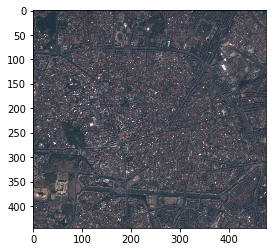

In [11]:
# since the data is a numpy array, let's try visualizing it with matplotlib
from matplotlib import pyplot as plt
plt.imshow(patch.data['TRUE-COLOR-S2-L1C'][0])

In [12]:
# try with other resolutions, layers, date ranges or areas
# also notice the additional information that the task adds to mask, meta_info and timestamp
# patch = EOPatch()
# patch.bbox = BBox((-77.04, 38.90, -77, 38.96), crs=CRS.WGS84)

# load_s2 = S2L1CWCSInput('BANDS-S2-L1C', resx='20m', resy='20m') # all bands
# load_s2.execute(eopatch=patch, time_interval=('2019-08-01', '2019-08-06'))

In [13]:
# now let's add some vector data, load a local file containing buildings
buildings = gpd.read_file('bucharest_buildings.geojson')

In [14]:
# we can add this file as either a vector (directly) or try transforming it to a raster
from eolearn.geometry import VectorToRaster
vtr_task = VectorToRaster(
    buildings,
    values=1,
    raster_shape=(FeatureType.DATA, 'TRUE-COLOR-S2-L1C'), # match the shape of our previous data
    raster_feature=(FeatureType.MASK_TIMELESS, 'BUILDING-DATA') # name our new layer
)

vtr_task.execute(eopatch=patch)

EOPatch(
  data: {
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(1, 445, 476, 3), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 445, 476, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    BUILDING-DATA: numpy.ndarray(shape=(445, 476, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-08-23', '2019-08-27')
  }
  bbox: BBox(((26.08, 44.42), (26.14, 44.46)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 8, 24, 9, 18, 3)]
)

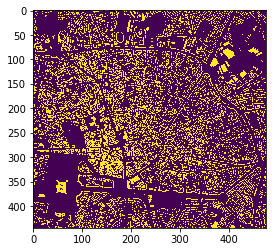

In [15]:
# now look at the buildings (also congrats, you're 50% of the way to being a geospatial machine learning engineer)
plt.imshow(patch.mask_timeless['BUILDING-DATA'].squeeze(2))

In [16]:
# we can also implement our own tasks, they need to:
# - inherit from the EOTask class
# - implement an __init__ method
# - implement an execute method which accepts an EOPatch as the first argument

# here's a template, try it out!
from eolearn.core import EOTask
    
patch = EOPatch()
patch.data['time_series'] = np.random.randint(1, 10, (10, 16, 16, 3))
    
# create a task for calculating a median pixel value
class MedianPixel(EOTask):
    """
    The task returns a pixelwise median value from a time-series and stores the results in a 
    timeless data array.
    """
    def __init__(self, input_feature, output_feature):
        self.input_feature = input_feature
        self.output_feature = output_feature

    def execute(self, eopatch):
        median = np.median(eopatch[self.input_feature[0]][self.input_feature[1]], axis=0)
        eopatch.add_feature(*self.output_feature, median)
        return eopatch
    
median_task = MedianPixel((FeatureType.DATA, 'time_series'), (FeatureType.DATA_TIMELESS, 'median'))
median_task.execute(patch)

EOPatch(
  data: {
    time_series: numpy.ndarray(shape=(10, 16, 16, 3), dtype=int64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    median: numpy.ndarray(shape=(16, 16, 3), dtype=float64)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

In [17]:
# finally let's save our patch
from eolearn.core import SaveToDisk, OverwritePermission

save = SaveToDisk('example', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

save.execute(eopatch=patch, eopatch_folder='this_patch')

EOPatch(
  data: {
    time_series: numpy.ndarray(shape=(10, 16, 16, 3), dtype=int64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    median: numpy.ndarray(shape=(16, 16, 3), dtype=float64)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

## EOWorkflow

- a **combination of `EOTask` objects** meant to accomplish a larger project
- builds a computational graph object to ensure all patches are processed in the same fashion

In [18]:
# rather than call .execute directly, let chain our tasks together
from eolearn.core import LinearWorkflow

workflow = LinearWorkflow(load_s2, vtr_task, save)

In [19]:
# now we can call this on any number of patches and pass the execution arguments to the workflow
patch = EOPatch()
bbox = BBox([26.08, 44.42, 26.14, 44.46], crs=CRS.WGS84)
patch.bbox = bbox
patches = [patch]

for patch in patches:
    workflow.execute({
        load_s2: { 'time_interval': ('2019-08-23', '2019-08-27'), 'bbox': bbox },
        vtr_task: {},
        save: { 'eopatch_folder': 'patch_idx' }
    }).eopatch()
    


## Practice

Take some time to experiment with different tasks and parameters before starting a larger workflow

# Water Monitoring

Let's try a larger workflow, "Measuring the water level of a Theewaterskloof Dam in South Africa", modified from the [`eo-learn` documentation](https://eo-learn.readthedocs.io/en/latest/examples/water-monitor/WaterMonitorWorkflow.html). There are more examples and documentation there you can check out after the workshop.

The outline of the workflow is:
- 1: Download all available Sentinel-2 satellite imagery of Theewaterskloof Dam from beginning of 2018 until today. We'll download `TRUE_COLOR` for nicer visualisations + `NDWI` for water detection
- 2: Clouds are very often obscuring the view of the ground. In order to correctly determine the water level of the dam all images with clouds need to be filtered out.
- 3: Apply adaptive thresholding to NDWI grayscale images
- 4: Extract water level from a comparison of measured water extent with the nominal one

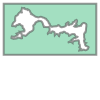

In [20]:
import shapely.wkt
# Use the local WKT file of the dam outline to create a buffered geometry
with open('theewaterskloof_dam_nominal.wkt', 'r') as f:
    dam_wkt = f.read()

dam_nominal = shapely.wkt.loads(dam_wkt)

# inflate the BBOX
inflate_bbox = 0.1
minx, miny, maxx, maxy = dam_nominal.bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox

dam_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)

dam_bbox.geometry - dam_nominal

## Intialize our EOTasks


In [21]:
## Imagery

# add true color Sentinel-2 data
input_task = S2L1CWCSInput('TRUE-COLOR-S2-L1C', resx='20m', resy='20m', maxcc=0.5, instance_id=None)

# add NDWI index from Sentinel-2
add_ndwi = S2L1CWCSInput('NDWI')

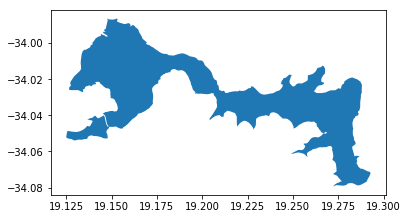

In [22]:
## Geometry

# load the dam boundary as a DataFrame
dam_gdf = gpd.GeoDataFrame(crs={'init':'epsg:4326'}, geometry=[dam_nominal])
dam_gdf.plot()

# convert to raster
add_nominal_water = VectorToRaster(dam_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1,
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

In [23]:
## Cloud and Valid Data Filtering
from eolearn.mask import AddCloudMaskTask, AddValidDataMaskTask, get_s2_pixel_cloud_detector
from eolearn.features import SimpleFilterTask

# add cloud classification
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
cloud_detection = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', cmask_feature='CLM', cprobs_feature='CLP', instance_id=None)

# if the pixel is clear, we count it as valid
def calculate_valid_data_mask(eopatch):
    return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                          np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

# calculate valid pixels per patch
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):

    def execute(self, eopatch):
        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape

        coverage = np.apply_along_axis(calculate_coverage, 1, valid_data.reshape((time, height * width * channels)))

        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch

add_coverage = AddValidDataCoverage()

# filter out scenes with too many clouds
class ValidDataCoveragePredicate:

    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        return calculate_coverage(array) < self.threshold

remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'), ValidDataCoveragePredicate(0.2))

/Users/andrewbollinger/.pyenv/versions/query-planet/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [24]:
## Water Detection
from skimage.filters import threshold_otsu

class WaterDetector(EOTask):

    @staticmethod
    def detect_water(ndwi):
        """
        Very simple water detector based on Otsu thresholding method of NDWI.
        """
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])

        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']

        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER'])
                                   for mask in water_masks])

        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])

        return eopatch

water_detection = WaterDetector()

## Define our EOWorkflow

In [25]:
workflow = LinearWorkflow(input_task, add_ndwi, cloud_detection, add_nominal_water, add_valid_mask, add_coverage, remove_cloudy_scenes, water_detection)

## Execute the workflow

In [26]:
# this takes a while
result = workflow.execute({
    input_task: {
        'bbox': dam_bbox,
        'time_interval': ['2018-01-01','2019-08-31']
    },
})

In [27]:
patch = result.eopatch()
patch

EOPatch(
  data: {
    CLP: numpy.ndarray(shape=(61, 618, 928, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(61, 618, 928, 1), dtype=float32)
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(61, 618, 928, 3), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(61, 618, 928, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(61, 618, 928, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(61, 618, 928, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(61, 618, 928, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(61, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(61, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(618, 928, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_in

## Plot the results

In [28]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))

    ax.imshow(eopatch.data['TRUE-COLOR-S2-L1C'][idx])

    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)

    ax.imshow(nominal, cmap=plt.cm.Reds)
    ax.imshow(observed, cmap=plt.cm.Blues)
    ax.axis('off')

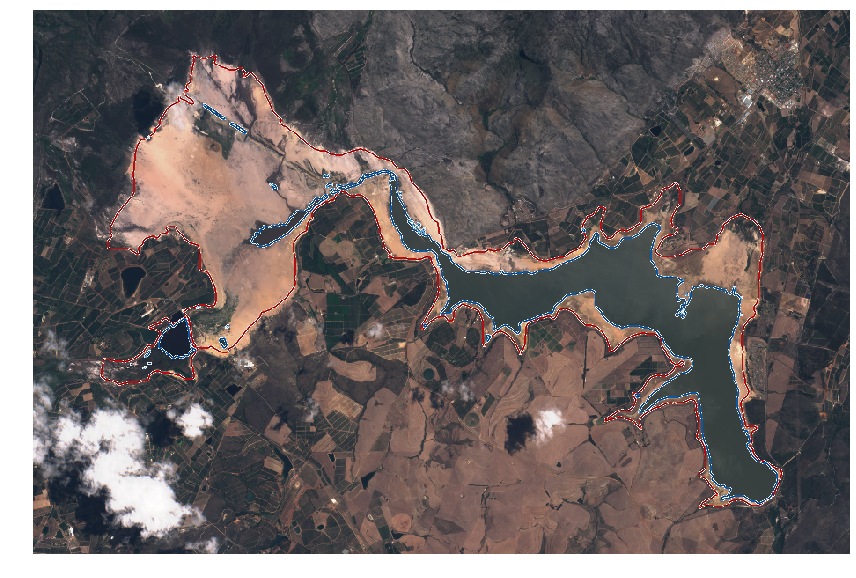

In [29]:
plot_rgb_w_water(patch, 0)

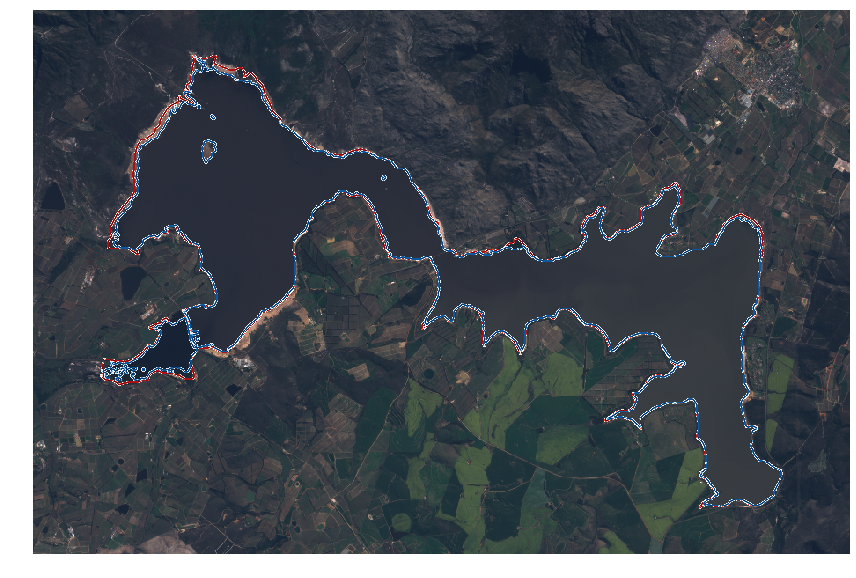

In [30]:
plot_rgb_w_water(patch, -1)

In [31]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20, 7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            'bo-', alpha=0.7)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            '--', color='gray', alpha=0.7)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water level')
    ax.set_title('Theewaterskloof Dam Water Levels')
    ax.grid(axis='y')
    return ax

/Users/andrewbollinger/.pyenv/versions/query-planet/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


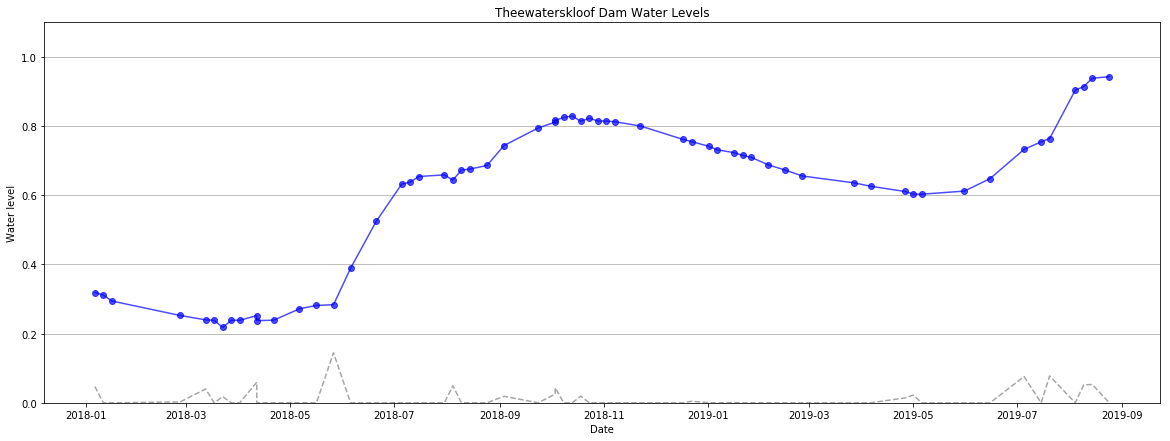

In [32]:
ax = plot_water_levels(patch, 1.0) # parameter is cloud cover filter

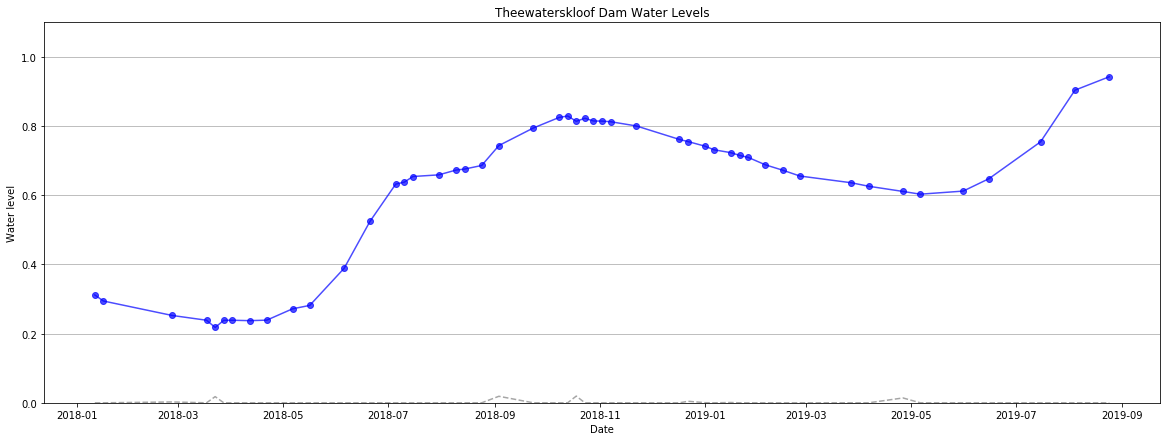

In [33]:
ax = plot_water_levels(patch, 0.02)